In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#splitting data
from sklearn.model_selection import train_test_split

#imbalances
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB

#xgboost, remember eval_metric='mlogloss' parameter to avoid warnings
from xgboost import XGBClassifier

#pipeline
from sklearn.pipeline import Pipeline

#random search
from sklearn.model_selection import RandomizedSearchCV

#accuracy testing
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score


#warnings
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [4]:
#there is an unbalance in the data outcome
# 0 = Not Bankrupt
# 1 = Bankrupt
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [5]:
bankrupt_labels = ['Not Bankrupt', 'Bankrupt']

In [6]:
#set x and y
X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']

In [7]:
#split training and testing samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [8]:
#SMOTE
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

### Logistic Regression Model

In [9]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [10]:
train_log_reg = log_reg.predict(X_train)

In [11]:
print(classification_report(y_train, train_log_reg, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.57      0.77      0.65      5286
    Bankrupt       0.64      0.42      0.50      5286

    accuracy                           0.59     10572
   macro avg       0.61      0.59      0.58     10572
weighted avg       0.61      0.59      0.58     10572



In [12]:
#test sample logistic regression
test_log_reg = log_reg.predict(X_test)

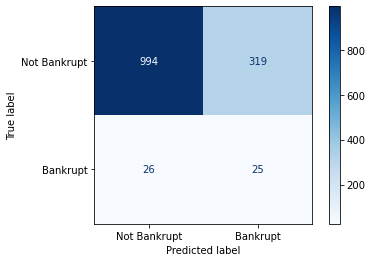

In [13]:
#plot train sample confusion matrix
plot_confusion_matrix(log_reg, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.Blues)

In [14]:
print(classification_report(y_test, test_log_reg, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.97      0.76      0.85      1313
    Bankrupt       0.07      0.49      0.13        51

    accuracy                           0.75      1364
   macro avg       0.52      0.62      0.49      1364
weighted avg       0.94      0.75      0.82      1364



In [15]:
print(cross_val_score(log_reg, X_test, y_test, scoring='accuracy', cv=10))

[0.94890511 0.94160584 0.96350365 0.94890511 0.96323529 0.96323529
 0.95588235 0.95588235 0.96323529 0.96323529]


In [16]:
print(cross_val_score(log_reg, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9567625590382137


In [17]:
print(cross_val_score(log_reg, X_test, y_test, scoring='accuracy', cv=10).std())

0.0075351323953538295


In [18]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_log_reg))
print('Mean Squared Error:', mean_squared_error(y_test, test_log_reg))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_log_reg)))

Mean Absolute Error: 0.2529325513196481
Mean Squared Error: 0.2529325513196481
Root Mean Squared Error: 0.5029240015346733


In [19]:
precision_score(y_test, test_log_reg)

0.07267441860465117

In [20]:
recall_score(y_test, test_log_reg)

0.49019607843137253

In [21]:
f1_score(y_test, test_log_reg)

0.12658227848101267

### Decision Tree

In [22]:
#pipeline decision tree
dtc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('dtc', DecisionTreeClassifier())
])

In [23]:
dtc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('dtc', DecisionTreeClassifier())])

In [24]:
dtc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'dtc', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'dtc__ccp_alpha', 'dtc__class_weight', 'dtc__criterion', 'dtc__max_depth', 'dtc__max_features', 'dtc__max_leaf_nodes', 'dtc__min_impurity_decrease', 'dtc__min_impurity_split', 'dtc__min_samples_leaf', 'dtc__min_samples_split', 'dtc__min_weight_fraction_leaf', 'dtc__random_state', 'dtc__splitter'])

In [25]:
param_grid_dtc = [{
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__max_depth': [10, 50],
    'dtc__min_samples_leaf': [10, 50],
    'dtc__min_samples_split': [5, 50]
}]

In [26]:
rand_search_dtc = RandomizedSearchCV(dtc_pipeline, param_grid_dtc)

rand_search_dtc.fit(X_train, y_train)
train_rand_search_dtc = rand_search_dtc.predict(X_train)

In [27]:
print(classification_report(y_train, train_rand_search_dtc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.98      0.98      5286
    Bankrupt       0.98      0.98      0.98      5286

    accuracy                           0.98     10572
   macro avg       0.98      0.98      0.98     10572
weighted avg       0.98      0.98      0.98     10572



In [28]:
#test sample random search decision tree
test_rand_search_dtc = rand_search_dtc.predict(X_test)

In [29]:
print(classification_report(y_test, test_rand_search_dtc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.95      0.96      1313
    Bankrupt       0.28      0.49      0.35        51

    accuracy                           0.93      1364
   macro avg       0.63      0.72      0.66      1364
weighted avg       0.95      0.93      0.94      1364



### -------

In [30]:
#hard code decision tree

In [31]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
#decision tree train set model
train_dtc = dtc.predict(X_train)

In [33]:
print(classification_report(y_train, train_dtc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       1.00      1.00      1.00      5286
    Bankrupt       1.00      1.00      1.00      5286

    accuracy                           1.00     10572
   macro avg       1.00      1.00      1.00     10572
weighted avg       1.00      1.00      1.00     10572



In [34]:
#decision tree test set model
test_dtc = dtc.predict(X_test)

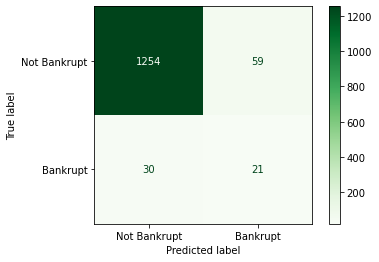

In [35]:
plot_confusion_matrix(dtc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.Greens)

In [36]:
print(classification_report(y_test, test_dtc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.96      0.97      1313
    Bankrupt       0.26      0.41      0.32        51

    accuracy                           0.93      1364
   macro avg       0.62      0.68      0.64      1364
weighted avg       0.95      0.93      0.94      1364



In [37]:
print(cross_val_score(dtc, X_test, y_test, scoring='accuracy', cv=10))

[0.95620438 0.91970803 0.95620438 0.95620438 0.94117647 0.97058824
 0.93382353 0.93382353 0.93382353 0.93382353]


In [38]:
print(cross_val_score(dtc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9427973379132675


In [39]:
print(cross_val_score(dtc, X_test, y_test, scoring='accuracy', cv=10).std())

0.017999015662305686


In [40]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_dtc))
print('Mean Squared Error:', mean_squared_error(y_test, test_dtc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_dtc)))

Mean Absolute Error: 0.06524926686217009
Mean Squared Error: 0.06524926686217009
Root Mean Squared Error: 0.25543936044034027


In [41]:
precision_score(y_test, test_dtc)

0.2625

In [42]:
recall_score(y_test, test_dtc)

0.4117647058823529

In [43]:
f1_score(y_test, test_dtc)

0.32061068702290074

### Random Forest

In [44]:
#pipeline decision tree
rfc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('rfc', RandomForestClassifier())
])

In [45]:
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('rfc', RandomForestClassifier())])

In [46]:
rfc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'rfc', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'rfc__bootstrap', 'rfc__ccp_alpha', 'rfc__class_weight', 'rfc__criterion', 'rfc__max_depth', 'rfc__max_features', 'rfc__max_leaf_nodes', 'rfc__max_samples', 'rfc__min_impurity_decrease', 'rfc__min_impurity_split', 'rfc__min_samples_leaf', 'rfc__min_samples_split', 'rfc__min_weight_fraction_leaf', 'rfc__n_estimators', 'rfc__n_jobs', 'rfc__oob_score', 'rfc__random_state', 'rfc__verbose', 'rfc__warm_start'])

In [47]:
param_grid_rfc = [{
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__max_depth': [10, 50],
    'rfc__min_samples_leaf': [10, 50],
    'rfc__min_samples_split': [5, 50]
}]

In [48]:
rand_search_rfc = RandomizedSearchCV(rfc_pipeline, param_grid_rfc)

rand_search_rfc.fit(X_train, y_train)
train_rand_search_rfc = rand_search_rfc.predict(X_train)

In [49]:
print(classification_report(y_train, train_rand_search_rfc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       1.00      0.97      0.98      5286
    Bankrupt       0.97      1.00      0.98      5286

    accuracy                           0.98     10572
   macro avg       0.99      0.98      0.98     10572
weighted avg       0.99      0.98      0.98     10572



In [50]:
#test sample random search decision tree
test_rand_search_rfc = rand_search_rfc.predict(X_test)

In [51]:
print(classification_report(y_test, test_rand_search_rfc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.95      0.97      1313
    Bankrupt       0.36      0.80      0.50        51

    accuracy                           0.94      1364
   macro avg       0.68      0.87      0.73      1364
weighted avg       0.97      0.94      0.95      1364



### -------

In [52]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [53]:
#random forest train set model
train_rfc = rfc.predict(X_train)

In [54]:
print(classification_report(y_train, train_rfc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       1.00      1.00      1.00      5286
    Bankrupt       1.00      1.00      1.00      5286

    accuracy                           1.00     10572
   macro avg       1.00      1.00      1.00     10572
weighted avg       1.00      1.00      1.00     10572



In [55]:
#random forest test set model
test_rfc = rfc.predict(X_test)

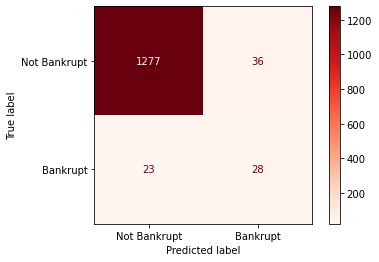

In [56]:
plot_confusion_matrix(rfc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.Reds)

In [57]:
print(classification_report(y_test, test_rfc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.97      0.98      1313
    Bankrupt       0.44      0.55      0.49        51

    accuracy                           0.96      1364
   macro avg       0.71      0.76      0.73      1364
weighted avg       0.96      0.96      0.96      1364



In [58]:
print(cross_val_score(rfc, X_test, y_test, scoring='accuracy', cv=10))

[0.96350365 0.96350365 0.95620438 0.95620438 0.96323529 0.97058824
 0.96323529 0.96323529 0.96323529 0.94852941]


In [59]:
print(cross_val_score(rfc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9618720480893087


In [60]:
print(cross_val_score(rfc, X_test, y_test, scoring='accuracy', cv=10).std())

0.008362648590138124


In [61]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_rfc))
print('Mean Squared Error:', mean_squared_error(y_test, test_rfc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_rfc)))

Mean Absolute Error: 0.04325513196480939
Mean Squared Error: 0.04325513196480939
Root Mean Squared Error: 0.20797868151522017


In [62]:
precision_score(y_test, test_rfc)

0.4375

In [63]:
recall_score(y_test, test_rfc)

0.5490196078431373

In [64]:
f1_score(y_test, test_rfc)

0.48695652173913045

### Adaboost Classifier

In [65]:
#pipeline decision tree
abc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('abc', AdaBoostClassifier())
])

In [66]:
abc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('abc', AdaBoostClassifier())])

In [67]:
abc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'abc', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'abc__algorithm', 'abc__base_estimator', 'abc__learning_rate', 'abc__n_estimators', 'abc__random_state'])

In [68]:
param_grid_abc = [{
    'abc__random_state': [5, 42]
}]

In [69]:
rand_search_abc = RandomizedSearchCV(abc_pipeline, param_grid_abc)

rand_search_abc.fit(X_train, y_train)
train_rand_search_abc = rand_search_abc.predict(X_train)

In [70]:
print(classification_report(y_train, train_rand_search_abc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.96      0.93      0.95      5286
    Bankrupt       0.94      0.96      0.95      5286

    accuracy                           0.95     10572
   macro avg       0.95      0.95      0.95     10572
weighted avg       0.95      0.95      0.95     10572



In [71]:
#test sample random search decision tree
test_rand_search_abc = rand_search_abc.predict(X_test)

In [72]:
print(classification_report(y_test, test_rand_search_abc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.92      0.96      1313
    Bankrupt       0.28      0.76      0.41        51

    accuracy                           0.92      1364
   macro avg       0.64      0.84      0.68      1364
weighted avg       0.96      0.92      0.94      1364



### -------

In [73]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

AdaBoostClassifier()

In [74]:
train_abc = abc.predict(X_train)

In [75]:
print(classification_report(y_train, train_abc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.96      0.94      0.95      5286
    Bankrupt       0.94      0.96      0.95      5286

    accuracy                           0.95     10572
   macro avg       0.95      0.95      0.95     10572
weighted avg       0.95      0.95      0.95     10572



In [76]:
#adaboost test set model
test_abc = abc.predict(X_test)

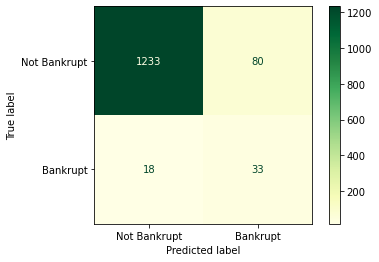

In [77]:
plot_confusion_matrix(abc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.YlGn)

In [78]:
print(classification_report(y_test, test_abc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.94      0.96      1313
    Bankrupt       0.29      0.65      0.40        51

    accuracy                           0.93      1364
   macro avg       0.64      0.79      0.68      1364
weighted avg       0.96      0.93      0.94      1364



In [79]:
print(cross_val_score(abc, X_test, y_test, scoring='accuracy', cv=10))

[0.94890511 0.94160584 0.96350365 0.96350365 0.97058824 0.96323529
 0.95588235 0.94117647 0.97058824 0.93382353]


In [80]:
print(cross_val_score(abc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9552812365822241


In [81]:
print(cross_val_score(abc, X_test, y_test, scoring='accuracy', cv=10).std())

0.012467967152775138


In [82]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_abc))
print('Mean Squared Error:', mean_squared_error(y_test, test_abc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_abc)))

Mean Absolute Error: 0.0718475073313783
Mean Squared Error: 0.0718475073313783
Root Mean Squared Error: 0.26804385337361925


In [83]:
precision_score(y_test, test_abc)

0.2920353982300885

In [84]:
recall_score(y_test, test_abc)

0.6470588235294118

In [85]:
f1_score(y_test, test_abc)

0.4024390243902439

### Bagging Classifier

In [86]:
#pipeline decision tree
bagc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('bagc', BaggingClassifier())
])

In [87]:
bagc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('bagc', BaggingClassifier())])

In [88]:
bagc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'bagc', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'bagc__base_estimator', 'bagc__bootstrap', 'bagc__bootstrap_features', 'bagc__max_features', 'bagc__max_samples', 'bagc__n_estimators', 'bagc__n_jobs', 'bagc__oob_score', 'bagc__random_state', 'bagc__verbose', 'bagc__warm_start'])

In [89]:
param_grid_bagc = [{
    'bagc__max_samples': [3000, 2000, 500],
    'bagc__random_state': [5, 42]
}]

In [90]:
rand_search_bagc = RandomizedSearchCV(bagc_pipeline, param_grid_bagc)

rand_search_bagc.fit(X_train, y_train)
train_rand_search_bagc = rand_search_bagc.predict(X_train)

In [91]:
print(classification_report(y_train, train_rand_search_bagc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.97      0.98      5286
    Bankrupt       0.97      0.99      0.98      5286

    accuracy                           0.98     10572
   macro avg       0.98      0.98      0.98     10572
weighted avg       0.98      0.98      0.98     10572



In [92]:
#test sample random search decision tree
test_rand_search_bagc = rand_search_bagc.predict(X_test)

In [93]:
print(classification_report(y_test, test_rand_search_bagc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.95      0.97      1313
    Bankrupt       0.35      0.69      0.46        51

    accuracy                           0.94      1364
   macro avg       0.67      0.82      0.72      1364
weighted avg       0.96      0.94      0.95      1364



### -------

In [94]:
bagc = BaggingClassifier()
bagc.fit(X_train, y_train)

BaggingClassifier()

In [95]:
train_bagc = bagc.predict(X_train)

In [96]:
print(classification_report(y_train, train_bagc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       1.00      1.00      1.00      5286
    Bankrupt       1.00      1.00      1.00      5286

    accuracy                           1.00     10572
   macro avg       1.00      1.00      1.00     10572
weighted avg       1.00      1.00      1.00     10572



In [97]:
#adaboost test set model
test_bagc = bagc.predict(X_test)

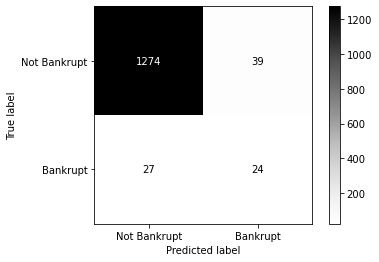

In [98]:
plot_confusion_matrix(bagc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.Greys)

In [99]:
print(classification_report(y_test, test_bagc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.97      0.97      1313
    Bankrupt       0.38      0.47      0.42        51

    accuracy                           0.95      1364
   macro avg       0.68      0.72      0.70      1364
weighted avg       0.96      0.95      0.95      1364



In [100]:
print(cross_val_score(bagc, X_test, y_test, scoring='accuracy', cv=10))

[0.97810219 0.96350365 0.96350365 0.96350365 0.95588235 0.96323529
 0.96323529 0.94117647 0.95588235 0.95588235]


In [101]:
print(cross_val_score(bagc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.961126019750966


In [102]:
print(cross_val_score(bagc, X_test, y_test, scoring='accuracy', cv=10).std())

0.007173963661026122


In [103]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_bagc))
print('Mean Squared Error:', mean_squared_error(y_test, test_bagc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_bagc)))

Mean Absolute Error: 0.04838709677419355
Mean Squared Error: 0.04838709677419355
Root Mean Squared Error: 0.21997067253202993


In [104]:
precision_score(y_test, test_bagc)

0.38095238095238093

In [105]:
recall_score(y_test, test_bagc)

0.47058823529411764

In [106]:
f1_score(y_test, test_bagc)

0.42105263157894735

### Gradient Boosting

In [107]:
#pipeline decision tree
gbc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('gbc', GradientBoostingClassifier())
])

In [108]:
gbc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('gbc', GradientBoostingClassifier())])

In [109]:
gbc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'gbc', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'gbc__ccp_alpha', 'gbc__criterion', 'gbc__init', 'gbc__learning_rate', 'gbc__loss', 'gbc__max_depth', 'gbc__max_features', 'gbc__max_leaf_nodes', 'gbc__min_impurity_decrease', 'gbc__min_impurity_split', 'gbc__min_samples_leaf', 'gbc__min_samples_split', 'gbc__min_weight_fraction_leaf', 'gbc__n_estimators', 'gbc__n_iter_no_change', 'gbc__random_state', 'gbc__subsample', 'gbc__tol', 'gbc__validation_fraction', 'gbc__verbose', 'gbc__warm_start'])

In [110]:
param_grid_gbc = [{
    'gbc__criterion': ['friedman_mse', 'squared_error'],
    'gbc__min_samples_leaf': [10, 50],
    'gbc__min_samples_split': [10, 50]
}]

In [111]:
rand_search_gbc = RandomizedSearchCV(gbc_pipeline, param_grid_gbc)

rand_search_gbc.fit(X_train, y_train)
train_rand_search_gbc = rand_search_gbc.predict(X_train)

In [112]:
print(classification_report(y_train, train_rand_search_gbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.96      0.97      5286
    Bankrupt       0.96      0.99      0.97      5286

    accuracy                           0.97     10572
   macro avg       0.97      0.97      0.97     10572
weighted avg       0.97      0.97      0.97     10572



In [113]:
#test sample random search decision tree
test_rand_search_gbc = rand_search_gbc.predict(X_test)

In [114]:
print(classification_report(y_test, test_rand_search_gbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.95      0.97      1313
    Bankrupt       0.36      0.75      0.48        51

    accuracy                           0.94      1364
   macro avg       0.67      0.85      0.73      1364
weighted avg       0.97      0.94      0.95      1364



### -------

In [115]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [116]:
train_gbc = gbc.predict(X_train)

In [117]:
print(classification_report(y_train, train_gbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.97      0.98      5286
    Bankrupt       0.97      0.99      0.98      5286

    accuracy                           0.98     10572
   macro avg       0.98      0.98      0.98     10572
weighted avg       0.98      0.98      0.98     10572



In [118]:
#gradient test set model
test_gbc = gbc.predict(X_test)

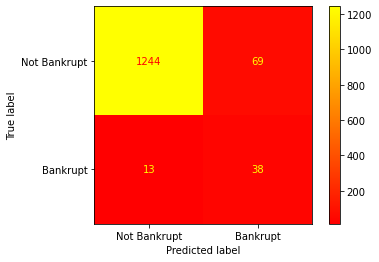

In [119]:
plot_confusion_matrix(gbc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.autumn)

In [120]:
print(classification_report(y_test, test_gbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.95      0.97      1313
    Bankrupt       0.36      0.75      0.48        51

    accuracy                           0.94      1364
   macro avg       0.67      0.85      0.72      1364
weighted avg       0.97      0.94      0.95      1364



In [121]:
print(cross_val_score(gbc, X_test, y_test, scoring='accuracy', cv=10))

[0.96350365 0.97080292 0.97810219 0.96350365 0.95588235 0.97794118
 0.97058824 0.94117647 0.97058824 0.94117647]


In [122]:
print(cross_val_score(gbc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9625912408759124


In [123]:
print(cross_val_score(gbc, X_test, y_test, scoring='accuracy', cv=10).std())

0.011659157516251776


In [124]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_gbc))
print('Mean Squared Error:', mean_squared_error(y_test, test_gbc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_gbc)))

Mean Absolute Error: 0.060117302052785926
Mean Squared Error: 0.060117302052785926
Root Mean Squared Error: 0.24518829917593116


In [125]:
precision_score(y_test, test_gbc)

0.35514018691588783

In [126]:
recall_score(y_test, test_gbc)

0.7450980392156863

In [127]:
f1_score(y_test, test_gbc)

0.48101265822784806

### KNeighbors Classifier

In [128]:
#pipeline decision tree
knc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('knc', KNeighborsClassifier())
])

In [129]:
knc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('knc', KNeighborsClassifier())])

In [130]:
knc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'knc', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'knc__algorithm', 'knc__leaf_size', 'knc__metric', 'knc__metric_params', 'knc__n_jobs', 'knc__n_neighbors', 'knc__p', 'knc__weights'])

In [131]:
param_grid_knc = [{
    'knc__metric' : ['manhattan', 'euclidiean', 'minkowski'],
    'knc__leaf_size': [1, 5, 10],
    'knc__n_jobs': [1, 3, 5],
    'knc__n_neighbors': [1, 3, 5]
}]

In [132]:
rand_search_knc = RandomizedSearchCV(knc_pipeline, param_grid_knc)

rand_search_knc.fit(X_train, y_train)
train_rand_search_knc = rand_search_knc.predict(X_train)

In [133]:
print(classification_report(y_train, train_rand_search_knc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       1.00      1.00      1.00      5286
    Bankrupt       1.00      1.00      1.00      5286

    accuracy                           1.00     10572
   macro avg       1.00      1.00      1.00     10572
weighted avg       1.00      1.00      1.00     10572



In [134]:
#test sample random search decision tree
test_rand_search_knc = rand_search_knc.predict(X_test)

In [135]:
print(classification_report(y_test, test_rand_search_knc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.95      0.96      1313
    Bankrupt       0.28      0.53      0.37        51

    accuracy                           0.93      1364
   macro avg       0.63      0.74      0.67      1364
weighted avg       0.95      0.93      0.94      1364



### -------

In [136]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)

KNeighborsClassifier()

In [137]:
#knearest neighbor train set model
train_knc = knc.predict(X_train)

In [138]:
print(classification_report(y_train, train_knc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.91      0.95      5286
    Bankrupt       0.92      0.99      0.95      5286

    accuracy                           0.95     10572
   macro avg       0.95      0.95      0.95     10572
weighted avg       0.95      0.95      0.95     10572



In [139]:
#knearest neighbor test set model
test_knc = knc.predict(X_test)

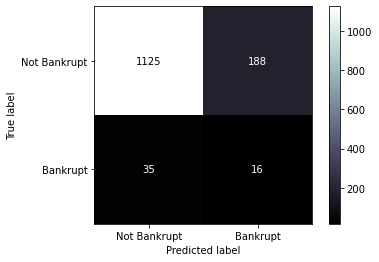

In [140]:
plot_confusion_matrix(knc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.bone)

In [141]:
print(classification_report(y_test, test_knc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.97      0.86      0.91      1313
    Bankrupt       0.08      0.31      0.13        51

    accuracy                           0.84      1364
   macro avg       0.52      0.59      0.52      1364
weighted avg       0.94      0.84      0.88      1364



In [142]:
print(cross_val_score(knc, X_test, y_test, scoring='accuracy', cv=10))

[0.95620438 0.96350365 0.97080292 0.95620438 0.96323529 0.96323529
 0.96323529 0.96323529 0.96323529 0.96323529]


In [143]:
print(cross_val_score(knc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9626127093173036


In [144]:
print(cross_val_score(knc, X_test, y_test, scoring='accuracy', cv=10).std())

0.0039029779963525237


In [145]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_knc))
print('Mean Squared Error:', mean_squared_error(y_test, test_knc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_knc)))

Mean Absolute Error: 0.16348973607038123
Mean Squared Error: 0.16348973607038123
Root Mean Squared Error: 0.4043386403379984


In [146]:
precision_score(y_test, test_knc)

0.0784313725490196

In [147]:
recall_score(y_test, test_knc)

0.3137254901960784

In [148]:
f1_score(y_test, test_knc)

0.12549019607843137

### Support Vector Classifier

In [149]:
#pipeline decision tree
svc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('svc', SVC())
])

In [150]:
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('svc', SVC())])

In [151]:
svc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'svc', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [152]:
param_grid_svc = [{
    'svc__random_state': [5, 42]
}]

In [153]:
rand_search_svc = RandomizedSearchCV(svc_pipeline, param_grid_svc)

rand_search_svc.fit(X_train, y_train)
train_rand_search_svc = rand_search_svc.predict(X_train)

In [154]:
print(classification_report(y_train, train_rand_search_svc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.94      0.96      5286
    Bankrupt       0.94      0.99      0.96      5286

    accuracy                           0.96     10572
   macro avg       0.96      0.96      0.96     10572
weighted avg       0.96      0.96      0.96     10572



In [155]:
#test sample random search decision tree
test_rand_search_svc = rand_search_svc.predict(X_test)

In [156]:
print(classification_report(y_test, test_rand_search_svc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.94      0.96      1313
    Bankrupt       0.29      0.61      0.39        51

    accuracy                           0.93      1364
   macro avg       0.64      0.78      0.68      1364
weighted avg       0.96      0.93      0.94      1364



### -------

In [157]:
svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [158]:
#knearest neighbor train set model
train_svc = svc.predict(X_train)

In [159]:
print(classification_report(y_train, train_svc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.88      0.80      0.84      5286
    Bankrupt       0.82      0.89      0.85      5286

    accuracy                           0.85     10572
   macro avg       0.85      0.85      0.85     10572
weighted avg       0.85      0.85      0.85     10572



In [160]:
#knearest neighbor test set model
test_svc = svc.predict(X_test)

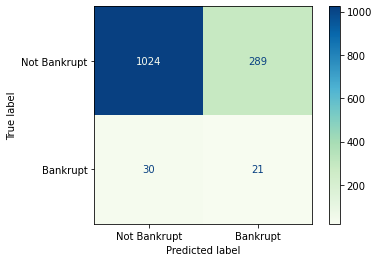

In [161]:
plot_confusion_matrix(svc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.GnBu)

In [162]:
print(classification_report(y_test, test_svc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.97      0.78      0.87      1313
    Bankrupt       0.07      0.41      0.12        51

    accuracy                           0.77      1364
   macro avg       0.52      0.60      0.49      1364
weighted avg       0.94      0.77      0.84      1364



In [163]:
print(cross_val_score(svc, X_test, y_test, scoring='accuracy', cv=10))

[0.96350365 0.96350365 0.96350365 0.95620438 0.96323529 0.96323529
 0.96323529 0.96323529 0.96323529 0.96323529]


In [164]:
print(cross_val_score(svc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9626127093173036


In [165]:
print(cross_val_score(svc, X_test, y_test, scoring='accuracy', cv=10).std())

0.0021394785627144317


In [166]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_svc))
print('Mean Squared Error:', mean_squared_error(y_test, test_svc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_svc)))

Mean Absolute Error: 0.23387096774193547
Mean Squared Error: 0.23387096774193547
Root Mean Squared Error: 0.4836020758246758


In [167]:
precision_score(y_test, test_svc)

0.06774193548387097

In [168]:
recall_score(y_test, test_svc)

0.4117647058823529

In [169]:
f1_score(y_test, test_svc)

0.11634349030470915

### Naive Bayes Bernoulli

In [170]:
#pipeline decision tree
bnbc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('bnbc', BernoulliNB())
])

In [171]:
bnbc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('bnbc', BernoulliNB())])

In [172]:
bnbc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'bnbc', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'bnbc__alpha', 'bnbc__binarize', 'bnbc__class_prior', 'bnbc__fit_prior'])

In [173]:
param_grid_bnbc = [{
}]

In [174]:
rand_search_bnbc = RandomizedSearchCV(bnbc_pipeline, param_grid_bnbc)

rand_search_bnbc.fit(X_train, y_train)
train_rand_search_bnbc = rand_search_bnbc.predict(X_train)

In [175]:
print(classification_report(y_train, train_rand_search_bnbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.86      0.85      0.85      5286
    Bankrupt       0.85      0.86      0.85      5286

    accuracy                           0.85     10572
   macro avg       0.85      0.85      0.85     10572
weighted avg       0.85      0.85      0.85     10572



In [176]:
#test sample random search decision tree
test_rand_search_bnbc = rand_search_bnbc.predict(X_test)

In [177]:
print(classification_report(y_test, test_rand_search_bnbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.86      0.92      1313
    Bankrupt       0.18      0.80      0.30        51

    accuracy                           0.86      1364
   macro avg       0.59      0.83      0.61      1364
weighted avg       0.96      0.86      0.90      1364



### -------

In [178]:
bnbc = BernoulliNB()
bnbc.fit(X_train, y_train)

BernoulliNB()

In [179]:
#knearest neighbor train set model
train_bnbc = bnbc.predict(X_train)

In [180]:
print(classification_report(y_train, train_bnbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.74      0.77      0.76      5286
    Bankrupt       0.76      0.73      0.75      5286

    accuracy                           0.75     10572
   macro avg       0.75      0.75      0.75     10572
weighted avg       0.75      0.75      0.75     10572



In [181]:
#knearest neighbor test set model
test_bnbc = bnbc.predict(X_test)

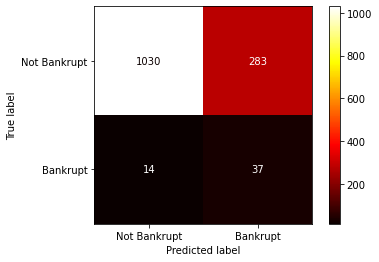

In [182]:
plot_confusion_matrix(bnbc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.hot)

In [183]:
print(classification_report(y_test, test_bnbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.99      0.78      0.87      1313
    Bankrupt       0.12      0.73      0.20        51

    accuracy                           0.78      1364
   macro avg       0.55      0.75      0.54      1364
weighted avg       0.95      0.78      0.85      1364



In [184]:
print(cross_val_score(bnbc, X_test, y_test, scoring='accuracy', cv=10))

[0.97080292 0.95620438 0.96350365 0.95620438 0.96323529 0.95588235
 0.96323529 0.96323529 0.95588235 0.97058824]


In [185]:
print(cross_val_score(bnbc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9618774151996565


In [186]:
print(cross_val_score(bnbc, X_test, y_test, scoring='accuracy', cv=10).std())

0.005476927706396938


In [187]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_bnbc))
print('Mean Squared Error:', mean_squared_error(y_test, test_bnbc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_bnbc)))

Mean Absolute Error: 0.21774193548387097
Mean Squared Error: 0.21774193548387097
Root Mean Squared Error: 0.4666282626286914


In [188]:
precision_score(y_test, test_bnbc)

0.115625

In [189]:
recall_score(y_test, test_bnbc)

0.7254901960784313

In [190]:
f1_score(y_test, test_bnbc)

0.19946091644204855

### XGBoost Classifier

In [191]:
#pipeline decision tree
xgbc_pipeline = Pipeline([
    ('ss', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='mlogloss'))
])

In [192]:
xgbc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='mlogloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [193]:
xgbc_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ss', 'xgb', 'ss__copy', 'ss__with_mean', 'ss__with_std', 'xgb__objective', 'xgb__use_label_encoder', 'xgb__base_score', 'xgb__booster', 'xgb__colsample_bylevel', 'xgb__colsample_bynode', 'xgb__colsample_bytree', 'xgb__gamma', 'xgb__gpu_id', 'xgb__importance_type', 'xgb__interaction_constraints', 'xgb__learning_rate', 'xgb__max_delta_step', 'xgb__max_depth', 'xgb__min_child_weight', 'xgb__missing', 'xgb__monotone_constraints', 'xgb__n_estimators', 'xgb__n_jobs', 'xgb__num_parallel_tree', 'xgb__random_state', 'xgb__reg_alpha', 'xgb__reg_lambda', 'xgb__scale_pos_weight', 'xgb__subsample', 'xgb__tree_method', 'xgb__validate_parameters', 'xgb__verbosity', 'xgb__eval_metric'])

In [194]:
param_grid_xgbc = [{
    'xgb__learning_rate': [0.1, 0.2, 0.3, 0.4],
    'xgb__gamma': [0, 1, 2, 3],
    'xgb__max_depth': [20,60],
    'xgb__min_child_weight': [1, 2],
    'xgb__subsample': [0.2, 0.5, 0.7, 0.9],
}]

In [195]:
rand_search_xgbc = RandomizedSearchCV(xgbc_pipeline, param_grid_xgbc)

rand_search_xgbc.fit(X_train, y_train)
train_rand_search_xgbc = rand_search_xgbc.predict(X_train)

In [196]:
print(classification_report(y_train, train_rand_search_xgbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       1.00      1.00      1.00      5286
    Bankrupt       1.00      1.00      1.00      5286

    accuracy                           1.00     10572
   macro avg       1.00      1.00      1.00     10572
weighted avg       1.00      1.00      1.00     10572



In [197]:
#test sample random search decision tree
test_rand_search_xgbc = rand_search_xgbc.predict(X_test)

In [198]:
print(classification_report(y_test, test_rand_search_xgbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.98      0.98      1313
    Bankrupt       0.48      0.55      0.51        51

    accuracy                           0.96      1364
   macro avg       0.73      0.76      0.75      1364
weighted avg       0.96      0.96      0.96      1364



### -------

In [199]:
xgbc = XGBClassifier(eval_metric='mlogloss')
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [200]:
#knearest neighbor train set model
train_xgbc = xgbc.predict(X_train)

In [201]:
print(classification_report(y_train, train_xgbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       1.00      1.00      1.00      5286
    Bankrupt       1.00      1.00      1.00      5286

    accuracy                           1.00     10572
   macro avg       1.00      1.00      1.00     10572
weighted avg       1.00      1.00      1.00     10572



In [202]:
#knearest neighbor test set model
test_xgbc = xgbc.predict(X_test)

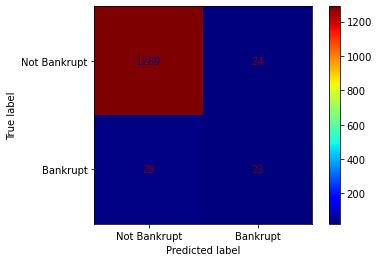

In [203]:
plot_confusion_matrix(xgbc, X_test, y_test, display_labels=bankrupt_labels, cmap=plt.cm.jet)

In [204]:
print(classification_report(y_test, test_xgbc, target_names=bankrupt_labels))

              precision    recall  f1-score   support

Not Bankrupt       0.98      0.98      0.98      1313
    Bankrupt       0.49      0.45      0.47        51

    accuracy                           0.96      1364
   macro avg       0.73      0.72      0.72      1364
weighted avg       0.96      0.96      0.96      1364



In [205]:
print(cross_val_score(xgbc, X_test, y_test, scoring='accuracy', cv=10))

[0.97080292 0.97080292 0.96350365 0.97080292 0.96323529 0.97058824
 0.97794118 0.96323529 0.97058824 0.93382353]


In [206]:
print(cross_val_score(xgbc, X_test, y_test, scoring='accuracy', cv=10).mean())

0.9655324173465006


In [207]:
print(cross_val_score(xgbc, X_test, y_test, scoring='accuracy', cv=10).std())

0.011439219822212316


In [208]:
print('Mean Absolute Error:', mean_absolute_error(y_test, test_xgbc))
print('Mean Squared Error:', mean_squared_error(y_test, test_xgbc))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, test_xgbc)))

Mean Absolute Error: 0.03812316715542522
Mean Squared Error: 0.03812316715542522
Root Mean Squared Error: 0.19525154840724113


In [209]:
precision_score(y_test, test_xgbc)

0.48936170212765956

In [210]:
recall_score(y_test, test_xgbc)

0.45098039215686275

In [211]:
f1_score(y_test, test_xgbc)

0.46938775510204084